In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
N_dis = 10**2   # 捨てる個数
N_trj = 10**3   # トータルのアップデート回数
N_sav = 10      # アップデート10回ごとに配位を保存
prm_list = [
    # beta, # of_trj, # of_discard, file_name, save_every
    # [1.00, N_trj, N_dis, "conf_tri/L32b025_", N_sav],  
    [0.54, N_trj, N_dis, "conf_tri/L32b090_", N_sav],  
    [0.51, N_trj, N_dis, "conf_tri/L32b090_", N_sav],
    [0.48, N_trj, N_dis, "conf_tri/L32b085_", N_sav],
    [0.45, N_trj, N_dis, "conf_tri/L32b080_", N_sav],
    [0.42, N_trj, N_dis, "conf_tri/L32b075_", N_sav],
    [0.39, N_trj, N_dis, "conf_tri/L32b070_", N_sav],
    [0.36, N_trj, N_dis, "conf_tri/L32b065_", N_sav],
    [0.33, N_trj, N_dis, "conf_tri/L32b060_", N_sav],
    [0.31, N_trj, N_dis, "conf_tri/L32b055_", N_sav],
    [0.29, N_trj, N_dis, "conf_tri/L32b050_", N_sav],
    [0.25, N_trj, N_dis, "conf_tri/L32b047_", N_sav],
    [0.23, N_trj, N_dis, "conf_tri/L32b040_", N_sav],
    [0.21, N_trj, N_dis, "conf_tri/L32b035_", N_sav],
    [0.18, N_trj, N_dis, "conf_tri/L32b030_", N_sav],
    [0.15, N_trj, N_dis, "conf_tri/L32b025_", N_sav],
    [0.12, N_trj, N_dis, "conf_tri/L32b020_", N_sav],
    [0.09, N_trj, N_dis, "conf_tri/L32b015_", N_sav],
    [0.06, N_trj, N_dis, "conf_tri/L32b010_", N_sav],
    [0.03, N_trj, N_dis, "conf_tri/L32b005_", N_sav],
    [0.00, N_trj, N_dis, "conf_tri/L32b000_", N_sav],
    ]

In [3]:
nconf = 90     # 各ベータでの配位の生成
betacr = 0.2747

data = []
labels = []
betas = []
nprm = len(prm_list)
for ibeta in range(nprm):
    beta = prm_list[ibeta][0]
    fname = prm_list[ibeta][3]
    for itrj in range(nconf):
        npsc = np.load(f"{fname}{itrj}.npy")
        data.append(npsc)
        if beta > betacr:
            labels.append([0, 1])   # 低温相の one-hot ベクトル
        else:
            labels.append([1, 0])   # 高温相の one-hot ベクトル
        betas.append(beta)
data = np.array(data)
labels = np.array(labels)

train_data = data[0::2]
train_labels = labels[0::2]
train_betas = betas[0::2]

val_data = data[1::2]
val_labels = labels[1::2]
val_betas = betas[1::2]

In [4]:
# データのサイズを確認
print("train_data.hape = ", train_data.shape)
print("val_data.hape = ", val_data.shape)

train_data.hape =  (900, 32, 32)
val_data.hape =  (900, 32, 32)


ここからモデルを定義して学習を行う．富谷さんの書籍ではtensorflowを用いているが，ここからはpytorchで実装を行う

In [5]:
# tensor型に変換
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
train_betas_tensor = torch.tensor(train_betas, dtype=torch.float32)

val_data_tensor = torch.tensor(val_data, dtype=torch.float32).unsqueeze(1)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)
val_betas_tensor = torch.tensor(val_betas, dtype=torch.float32)

In [6]:
# データセットの作成
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor, train_betas_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor, val_betas_tensor)

In [7]:
# DataLoaderの設定（バッチサイズ32）
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
# サイズを確認
train_data, train_label, train_beta = next(iter(train_loader))
train_data.shape, train_label.shape, train_beta.shape

(torch.Size([32, 1, 32, 32]), torch.Size([32, 2]), torch.Size([32]))

In [8]:
# モデルを定義
class CNN(nn.Module):
    def __init__(self, hidden_size, output_size, in_channels, out_channels):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=4, bias=False)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(out_channels*8*8, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.relu(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [9]:
# モデルのインスタンス化
in_channels  = 1
out_channels = 1
hidden_size = 100
output_size = 2
model = CNN(hidden_size, output_size, in_channels, out_channels)
# モデルの概要表示
print(model)

CNN(
  (conv): Conv2d(1, 1, kernel_size=(4, 4), stride=(4, 4), bias=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=64, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [10]:
# 損失関数と最適化手法を定義
criterion = nn.BCELoss()   # バイナリクロスエントロピー誤差
optimizer = optim.Adam(model.parameters(), lr=0.001)     # Adam

In [11]:
# 学習の実行
num_epochs = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    # train loop
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets, beta in train_loader:
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)      
        targets = torch.argmax(targets, dim=1)  
        running_acc += torch.mean(pred.eq(targets).float().cpu()) 
        optimizer.step()
    running_loss /= len(train_loader)   
    running_acc /= len(train_loader)    
    train_losses.append(running_loss)
    train_accs.append(running_acc)

    #   val loop
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_inputs, val_targets, val_beta in val_loader:
        val_output = model(val_inputs)
        val_loss = criterion(val_output, val_targets)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)      
        val_targets = torch.argmax(val_targets, dim=1)  
        val_running_acc += torch.mean(val_pred.eq(val_targets).float().cpu()) 
    val_running_loss /= len(val_loader)   
    val_running_acc /= len(val_loader)    
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
        
    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 0.5894376430018194, acc: 0.5269396305084229, val loss: 0.45921444584583415, val acc: 0.8448275923728943
epoch: 1, loss: 0.3882072012999962, acc: 0.9159482717514038, val loss: 0.31893364256569023, val acc: 0.954741358757019
epoch: 2, loss: 0.29919393566148034, acc: 0.9741379022598267, val loss: 0.25869060542177535, val acc: 0.9795258641242981
epoch: 3, loss: 0.23742381046558247, acc: 0.9870689511299133, val loss: 0.20490152318961918, val acc: 0.9903017282485962
epoch: 4, loss: 0.18728015340607743, acc: 0.9946120977401733, val loss: 0.15663993144648727, val acc: 0.9946120977401733
epoch: 5, loss: 0.13993819520391268, acc: 0.9967672228813171, val loss: 0.11631696909296743, val acc: 0.9978448152542114
epoch: 6, loss: 0.1023414070750105, acc: 0.9989224076271057, val loss: 0.08514453091754995, val acc: 0.9989224076271057
epoch: 7, loss: 0.07234955816690264, acc: 1.0, val loss: 0.06353919184565994, val acc: 0.9989224076271057
epoch: 8, loss: 0.053880338717637394, acc: 1.0, val

0.54 0.061299767 0.93010366
0.51 0.061299767 0.93010366
0.48 0.061299767 0.93010366
0.45 0.06130256 0.9301009
0.42 0.061299767 0.93010366
0.39 0.061299767 0.93010366
0.36 0.06151883 0.92984813
0.33 0.063003145 0.92819875
0.31 0.06522505 0.92620164
0.29 0.112665646 0.8753774
0.25 0.9992963 0.00074328034
0.23 0.99982053 0.00018679527
0.21 0.99868315 0.0013583195
0.18 0.99884 0.0012424618
0.15 0.9976857 0.0022312468
0.12 0.99699205 0.0029872477
0.09 0.9980661 0.0019080308
0.06 0.9971907 0.0027850629
0.03 0.996423 0.0035720854
0.0 0.9968376 0.0033097155


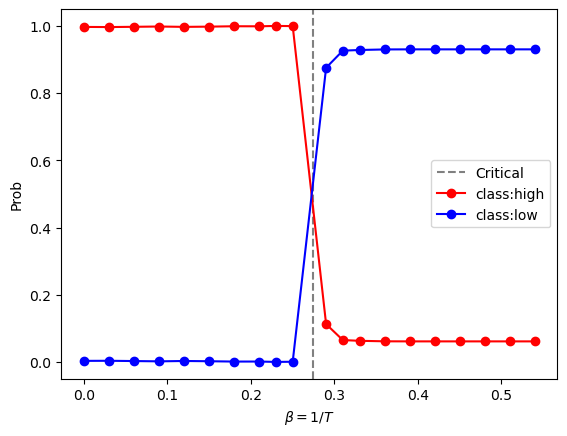

In [12]:
# 各逆温度での予測(確率)を可視化
xs = []
y1s = []
y2s = []
Ndatamax = 900
Nsameclass = 45
for ii in range(0, Ndatamax, Nsameclass):
    val_data = val_data_tensor
    res = model(val_data[ii : ii+Nsameclass])
    x = val_betas[ii]
    y1 = np.mean(res.detach().numpy().T[0])
    y2 = np.mean(res.detach().numpy().T[1])    
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    print(x, y1, y2)
plt.axvline(x=0.2747, ymin=0, ymax=1, ls="dashed", color="gray", label="Critical")
plt.plot(xs, y1s, label="class:high", marker="o", color="red")
plt.plot(xs, y2s, label="class:low", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$\beta = 1/T$")
plt.ylabel(r"Prob")
# 図をファイルとして保存
plt.savefig('plot_triangle_CNN.png')  # ファイル名を適切に指定
plt.show()